In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import *
from folium import plugins
from folium.plugins import HeatMap
import folium

Load the historical police incidence reports, 2003 to may 2018 and subselect the relevant focus-crimes.

In [2]:
policedata = pd.read_csv("../../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
# Generate and add relevant columns and types
policedata['DateTime'] = policedata['Date'] + ' ' + policedata['Time']
policedata['DateTime'] = pd.to_datetime(policedata['DateTime'] , format="%m/%d/%Y %H:%M")
policedata.Date = pd.to_datetime(policedata.Date)
policedata['Hour'] = pd.to_datetime(policedata.Time).dt.hour
policedata['DayOfWeek'] = policedata.Date.dt.dayofweek
policedata['Month'] = policedata.Date.dt.month
policedata['Minutes'] = pd.to_datetime(policedata.Time).dt.minute
policedata['TimeFormatted'] = pd.to_datetime(policedata['Time']).dt.time
policedata['X'] = policedata['X'].astype(float)
policedata['Y'] = policedata['Y'].astype(float)

# Select the relevant focus-crimes
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
fcdata = policedata[policedata['Category'].isin(list(focuscrimes))]

# Part 1: Temporal Patterns

#### Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. [Here's what my version looks like](https://raw.githubusercontent.com/suneman/socialdataanalysis2020/master/files/weekdays.png). Some things make sense - for example `drunkenness` and the weekend. But there are some aspects that were surprising to me. Check out `prostitution` and mid-week behavior, for example!?

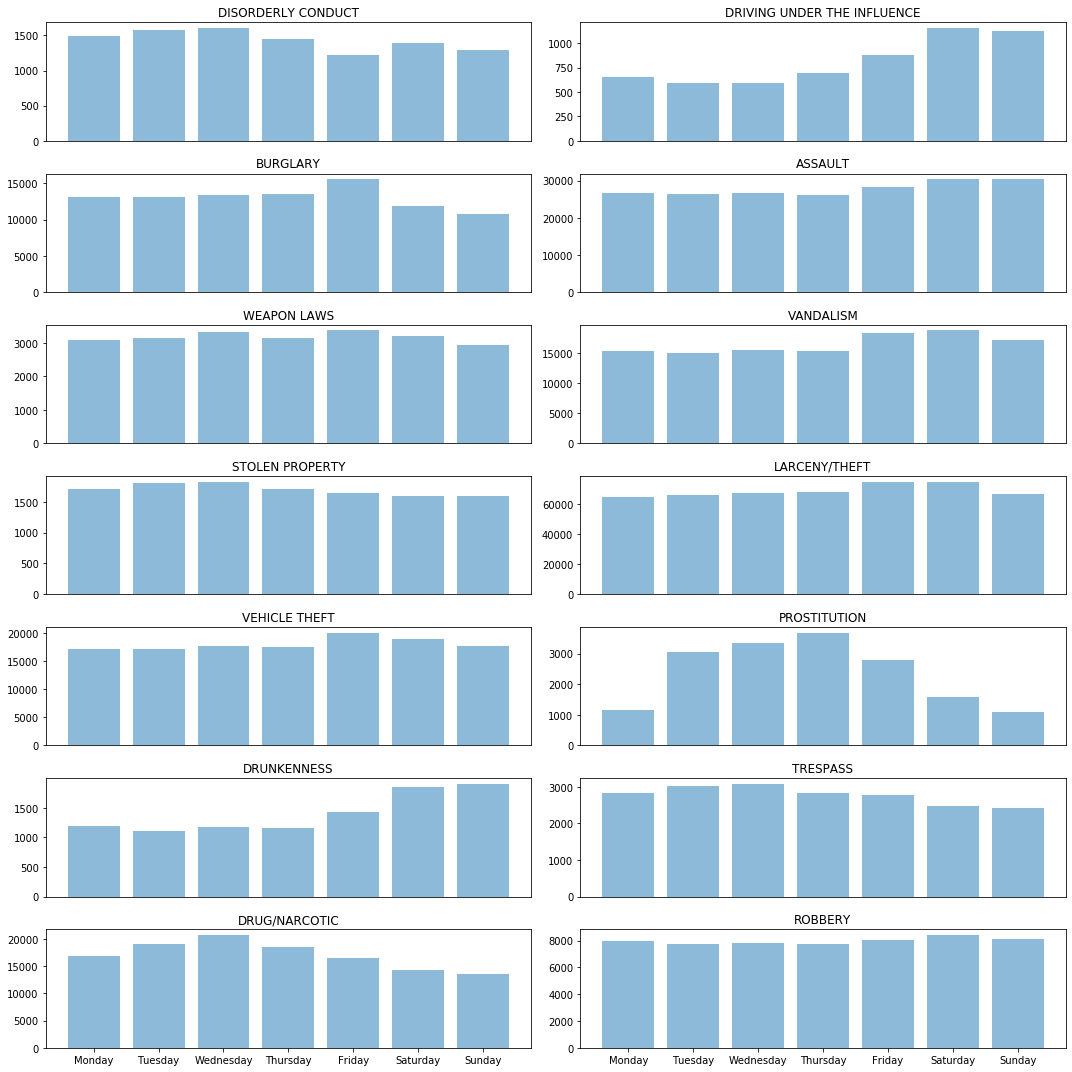

In [3]:
fig = plt.figure(figsize=(15,15))
plotidx = 1
for crimecat in list(focuscrimes):
    crimetype = fcdata[fcdata['Category'] == crimecat]
    groupedcrimetype = crimetype.groupby(crimetype.DateTime.dt.weekday).count()
    fig.add_subplot(7,2,plotidx)
    plt.bar(groupedcrimetype['IncidntNum'].index, groupedcrimetype['IncidntNum'].values, align='center', alpha=0.5)
    if plotidx == 13 or plotidx == 14:
        bars = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday')
        y_pos = np.arange(len(bars))
        plt.xticks(y_pos, bars)
    else:
        plt.xticks([])
    plt.title(crimecat)
    plt.tight_layout()
    plotidx += 1

From the barcharts it is clear that some crimes are much more frequent than others, as seen when looking on the values on the y-axis on each barchart. Here we see that Larceny/Theft is much more frequent, compared to for example Drunkenness.
Additionally it is seen that some crimes are very subject to changes in frequency throughout the week whereas others are not. Looking at Prostitution there is a clear peak at the middle of the week, while crimes such as Drunkenness and Driving under the inlfuence are more common during weekeneds.

#### *The months*. We can also check if some months are worse by counting up number of crimes in Jan, Feb, ..., Dec. Did you see any surprises there?

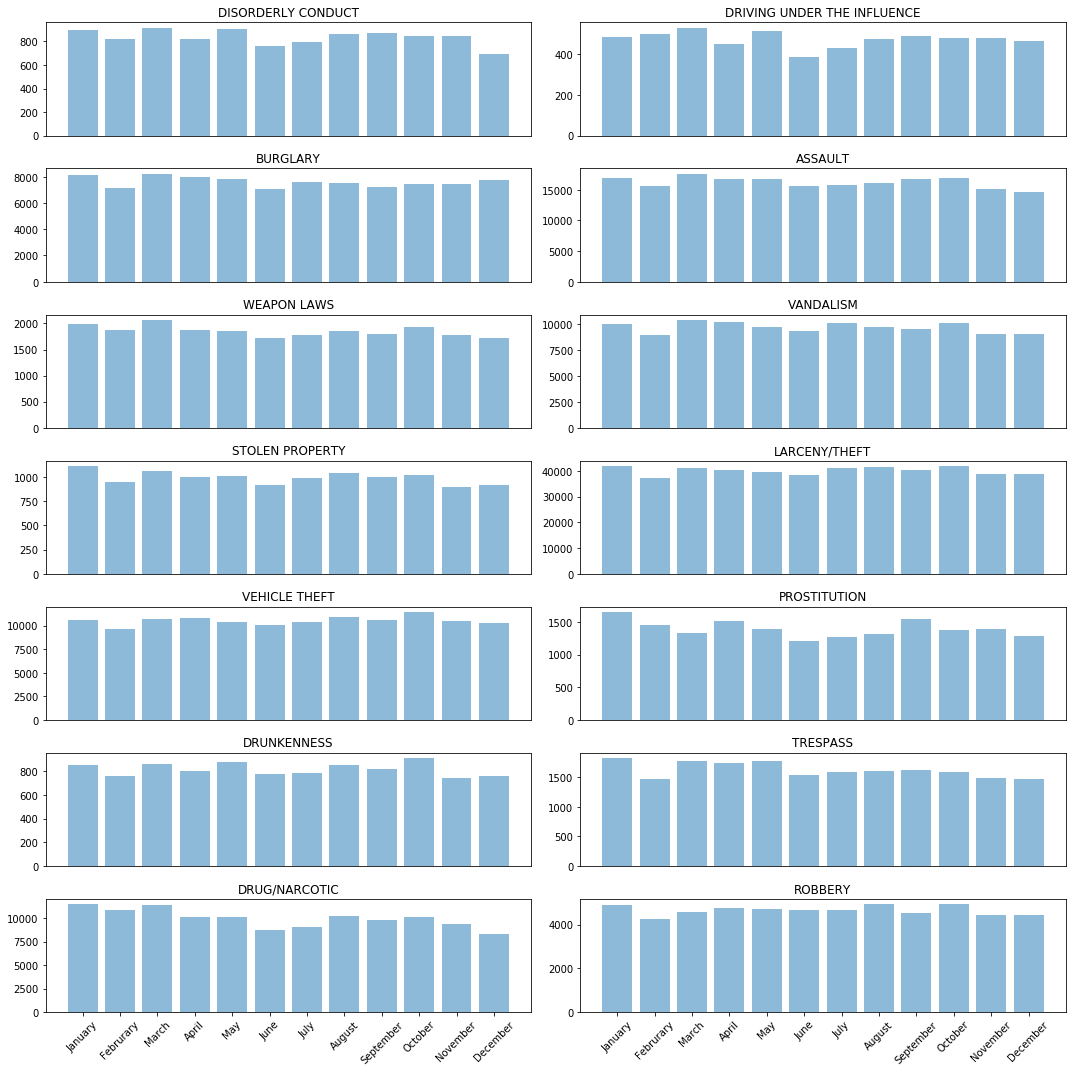

In [4]:
fig = plt.figure(figsize=(15,15))
plotidx = 1
for crimecat in list(focuscrimes):
    crimetype = fcdata[fcdata['Category'] == crimecat]
    groupedcrimetype = crimetype.groupby(crimetype.DateTime.dt.month).count()
    fig.add_subplot(7,2,plotidx)
    plt.bar(groupedcrimetype['IncidntNum'].index, groupedcrimetype['IncidntNum'].values, align='center', alpha=0.5)
    if plotidx == 13 or plotidx == 14:
        bars = ('January', 'Februrary', 'March', 'April', 'May', 'June', 'July', 'August','September','October','November','December')
        y_pos = np.arange(1,len(bars)+1)
        plt.xticks(y_pos, bars)
        plt.xticks(rotation=45) 
    else:
        plt.xticks([])
    plt.title(crimecat)
    plt.tight_layout()
    plotidx += 1

From the barcharts it is clear that some crimes are more subject frequent at varying times of the year. When judging across all crimes it appearst that the least frequent periods of crimes (or arrests) is during the summer. This is especially true for Prostitution and Drug/Narcotic - perhaps the lacking shroud of darkness keeps criminals at bay, or policemen like to take vacations in the summer and are therefore understaffed. February also generally has fewer arrests than the surrounding months, which is likely due to the month being shorter.

#### *The 24 hour cycle*. We'll can also forget about weekday and simply count up the number of each crime-type that occurs in the entire dataset from midnight to 1am, 1am - 2am ... and so on. Again: Give me a couple of comments on what you see. 

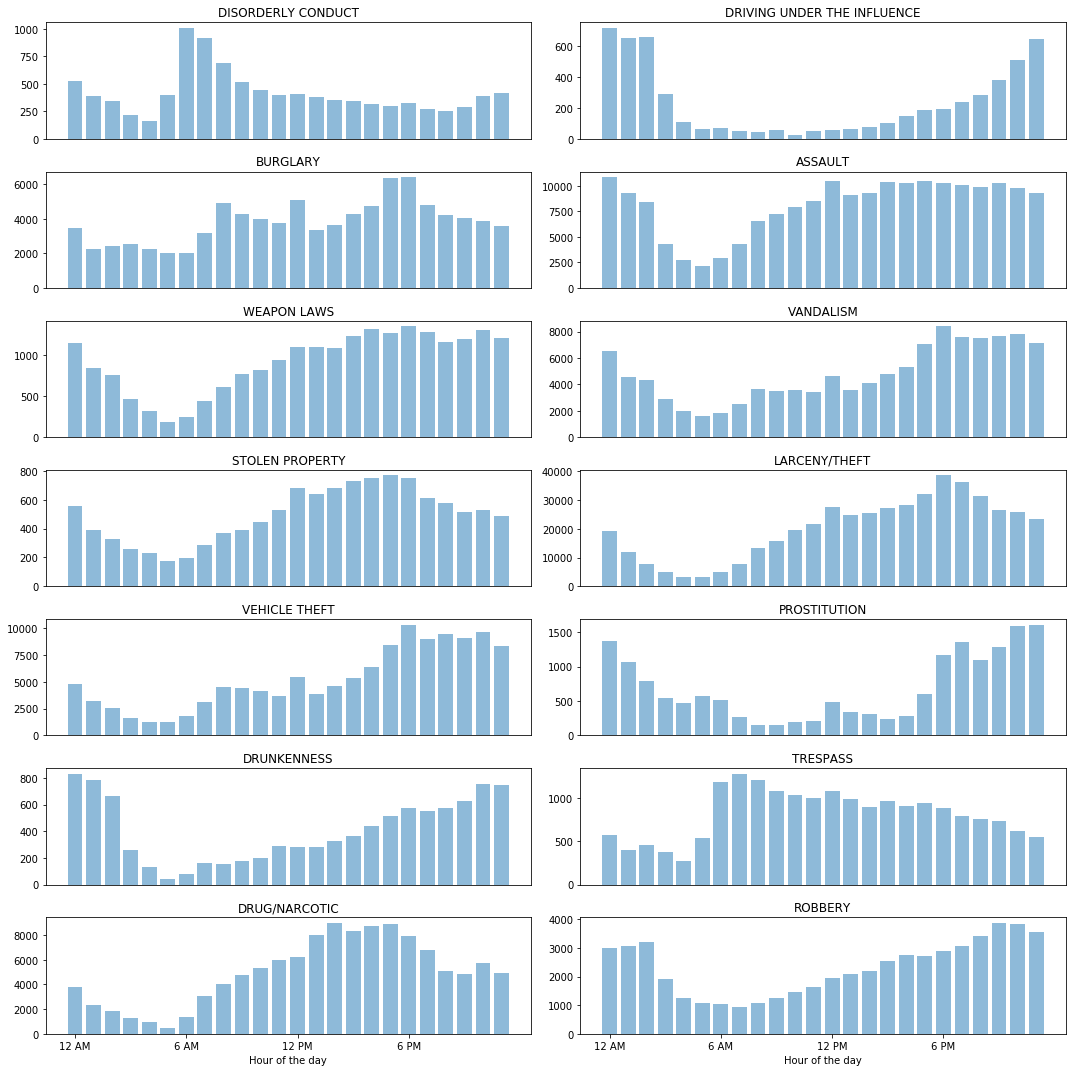

In [5]:
fig = plt.figure(figsize=(15,15))
plotidx = 1
for crimecat in list(focuscrimes):
    crimetype = fcdata[fcdata['Category'] == crimecat]
    groupedcrimetype = crimetype.groupby(crimetype.DateTime.dt.hour).count()
    fig.add_subplot(7,2,plotidx)
    plt.bar(groupedcrimetype['IncidntNum'].index, groupedcrimetype['IncidntNum'].values, align='center', alpha=0.5)
    plt.title(crimecat)
    if plotidx == 13 or plotidx == 14:
        plt.xlabel("Hour of the day")
        bars = ('12 AM', '6 AM', '12 PM', '6 PM')
        y_pos = (0,6,12,18)
        plt.xticks(y_pos, bars)
    else:
        plt.xticks([])
    plt.tight_layout()
    plotidx += 1

From the barchart we see that the hour of the day has a big impact on the occurences of a particular crime. For most of the crimes it seems that nighttime and early mornings are the most frequent times for the crimes. Looking at Driving under the influence this pattern is especially clear, since there are almost no arrest during the daytime. Trespassing and Disorderly Conduct is more common during the morning hours after 5 AM. Looking at burglary there seem to be two peaks, a larger one around 6 PM, and a smaller one around 12 PM - perhaps the earlier burglaries are related to peoples houses when they are out of house, and the later ones are associated with burglary of workplaces when workers are out of office.

#### *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight.

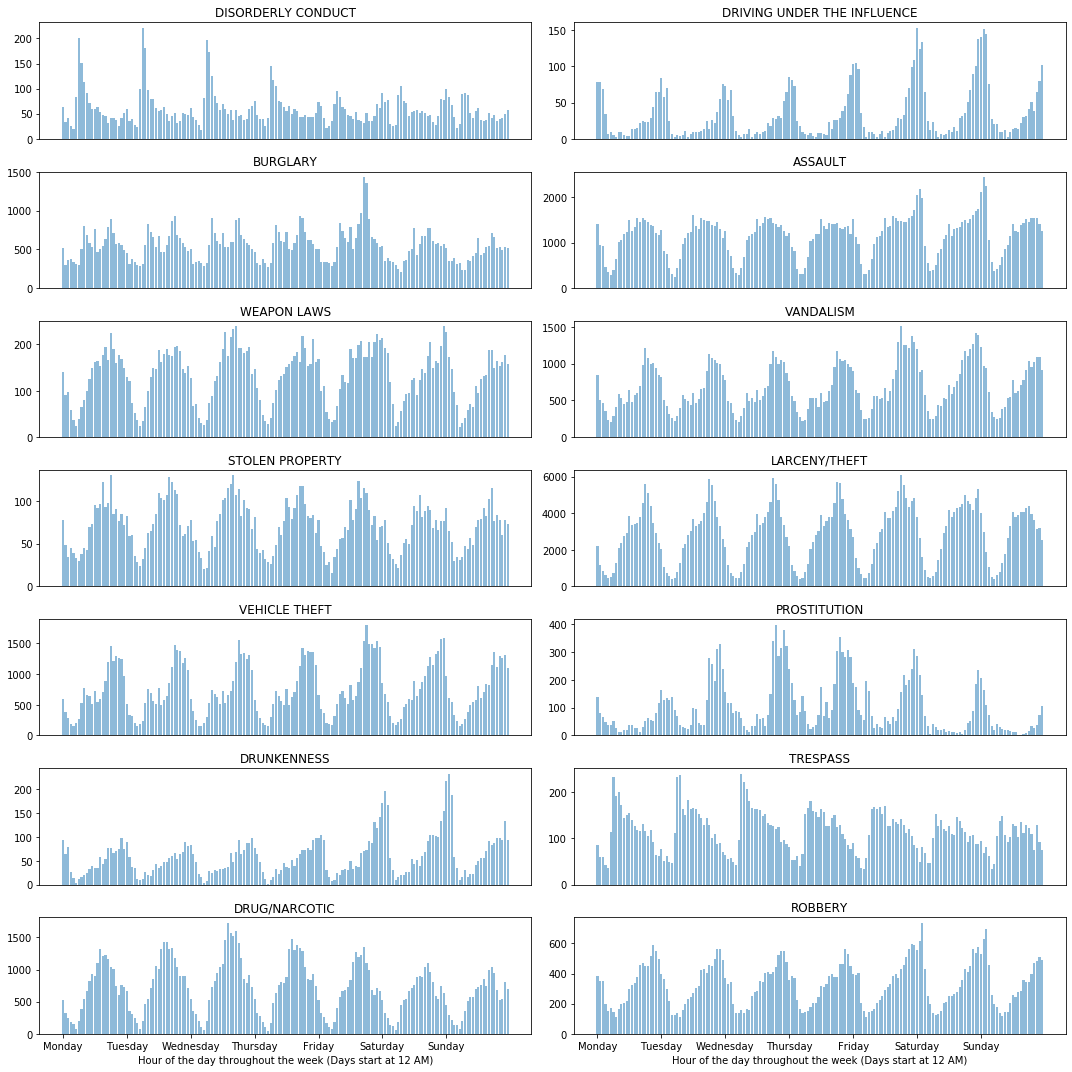

In [6]:
fig = plt.figure(figsize=(15,15))

plotidx = 1
for crimecat in list(focuscrimes):
    crimetype = fcdata[fcdata['Category'] == crimecat]
    groupedcrimetype = crimetype.groupby([crimetype.DateTime.dt.dayofweek , crimetype.DateTime.dt.hour]).count()
    groupedcrimetype.index = groupedcrimetype.index.set_names(['day', 'hour'])
    groupedcrimetype.reset_index(inplace=True)
    fig.add_subplot(7,2,plotidx)
    plt.bar(groupedcrimetype['IncidntNum'].index, groupedcrimetype['IncidntNum'].values, align='center', alpha=0.5)
    plt.title(crimecat)
    if plotidx == 13 or plotidx == 14:
        plt.xlabel("Hour of the day throughout the week (Days start at 12 AM)")
        bars = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday')
        y_pos = (0, 24, 48, 72, 96, 120, 144)
        plt.xticks(y_pos, bars)
    else:
        plt.xticks([])
    plt.tight_layout()
    plotidx += 1

From the barchart we see that some crimes have similar hourly patterns for each day, whereas other crimes patterns change depending on the day of the week. In addition the the change in pattern it is still evident that some crimes are more frequent at varying days, as was also seen on the very first plot. When looking at Burglary there is a clear peak around late friday night. It is noted that Disorderly Conduct is more frequent on weekday early mornings (especially tuesday, wednesday and thursday morning are most frequent). When looking at Assault, there are clear peaks at friday and saturday midnights, perhaps associated with a similar increase in Drunkenness during these hours.

# Part 2: Thinking about data and visualization

#### *Excercise:* Questions for the [first video lecture](https://www.youtube.com/watch?v=9D2aI30AMhM).
#### * What is the difference between *data* and *metadata*? How does that relate to the bike-example?

Data is collection of information which could be measurements, descriptions of things or facts related to something. Metadata is described as data on data, which is informations about these measurements, descriptions or facts. When taking a digital photo, the data will be associated with the pixels and their coloring, whereas the metadata is information about the data, such as how it is stored, what date the picture was taken on and the location of the photo.
In the bike-example the data is actually the GPS-coordinates (measurements that are recorded) - with the metadata being information provided by Google Earth, which is what are the surroundings of these measurements, and at what time were they recorded - thus enabling a presentation of the movement shown in the above youtube video.

#### * Sune says that the human eye is a great tool for data analysis. Do you agree? Explain why/why not. Mention something that the human eye is very good at. Can you think of something that [is difficult for the human eye](http://cdn.ebaumsworld.com/mediaFiles/picture/718392/84732652.jpg). Explain why your example is difficult. 

For some visualisation the human data is a great tool for data analysis, given the right visualisation information is easily extracted as the human eye is very good at noticing patterns quickly, which is also a feat many algorithms try to replicate. However there are limits to the human eye - the human eye is not very good at sorting through information quickly, and identifying outliers through a manual search, which is mostly what is done in a typical "Wheres Waldo" comic book game. Additionally the human eye is restricted to viewing in 3 dimensions, which is not a restrictions many statistical and machine learning models do not have, therefore it can be hard to identify patterns in high-dimensional spaces using just visualisation.

#### * Simpson's paradox is hard to explain. Come up with your own example - or find one on line.

A (real) example of the Simpson's paradox is the following:
There are two types of kidney stones (small and large) and two types of treatments (traditional and advanced surgical). One would expect that the advanced surgical procedure would be better, but this showed to not be the case when aggregating the data for both kidney stones. The reason for this was that the smaller kidney stones were generally treated with the traditional method and larger kidney stones generally treated with the advanced method. However since the larger kidney stone patients were more prone to being insuccesful (since a larger risk was involved), the traditional method seemed to be the better one, however when looking at the two groups individually, it was always the case that the advanced treatment were the one with the highest succesrate.

#### * In your own words, explain the difference between *exploratory* and *explanatory* data analysis. 

Exporatory data analysis is the purpose of digging into the data and identifying interesting patterns. To this end, visualisation serve a great purpose, as they give a quick overview of patterns which may be valuable to further delve in to. It is commonly done in the early stages of a project. The exploratory data analysis can help in identifying hypothesis for further testing.

Explanatory data analysis is more related to explaining a hypothesis one might have regarding a certain subject (this hypothesis could be acquired through exploratory data analysis for example). This can be done by controlled experiment designs and analysis of these, which can help reduce noise in the data and focus on what is desired.

#### *Excercise:* Questions for the [second video lecture](https://www.youtube.com/watch?v=yiU56codNlI).
#### * As mentioned earlier, visualization is not the only way to test for correlation. We can (for example) calculate the Pearson correlation. Explain in your own words how the Pearson correlation works and write down it's mathematical formulation. Can you think of an example where it fails (and visualization works)?

The Pearson correlation is defined as follows:

$\rho_{X, Y}=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}$

Where the numerator is the covariance between two variables, and the denominator is the product of each variables standard deviation. The method checks if two variables co-vary (using the covariance) in relation to how much they generally vary. If the two variables generally follow each other (high together, low together) a correaltion close to 1 will be the result. If the two variables are inverse of each other (one high, one low and vice versa) the correlation will be close to -1.
Some examples of the correlation failing despite having a clear connection between two variables could be if the relation is non-linear, such as a sine-function. The sine-function will very systematically vary with the input-variable, but the correlation between the two will be 0. In this case, a visualization will give a clear indication of the relations between the two variables.

#### * What is the difference between a bar-chart and a histogram?

A bar chart is used for counting frequencies for different groups or categories. A histogram is used to give insights into the distribution of a single variable across the possible variable-value interval. 

* I mention in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 

There are several ways to choose the right bin size for your histogram. One of these ways is to use Sturge's rule, which says that the number of bins should be corresponding to the number of observations in the data set. Sturge's rule is as follwos:

K = 1 + 3. 322 log(N)

Where K is the number of bins in the histogram, and N is the number of observations in the data set. The mehtod has however been critized for over-smoothing, and serves better as a rule of thumb.

In general the number of bins should reflect what the data is like. The smaller the bins the more detailed the histogram will be, but it includes a risk of accidnetally finding systematic behaviours in the data which are due to random noise. However a too large binsize will result in aggregating data over too large intervals, hiding potential patterns. There is no clear answer to what the bin-size should be, but a middle-ground is often desired. It all depends on the data and what one wishies to achieve from the histogram.

# Part 3: Generating important plot types
#### Excercise: Let us recreate some plots from DAOST but using our own favorite dataset.

#### * First, let's make a jitter-plot (that is, code up something like Figure 2-1 from DAOST from scratch), but based on SF Police data. My hunch from inspecting the file is that the police-folks might be a little bit lazy in noting down the exact time down to the second. So choose a crime-type and a suitable time interval (somewhere between a month and 6 months depending on the crime-type) and create a jitter plot of the arrest times during a single hour (like 13-14, for example). So let time run on the $x$-axis and create vertical jitter.

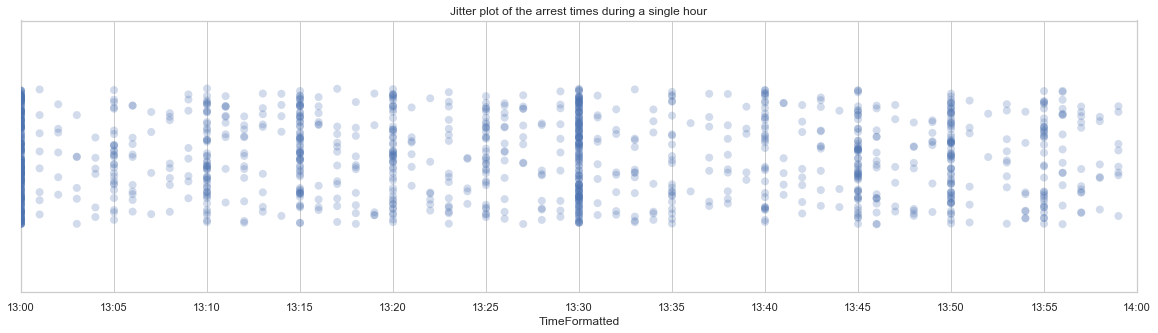

In [7]:
# Filter the data by category, time, and date
df1=policedata[(policedata["Category"] == 'ASSAULT') 
             & (policedata['Time'] < '14:00') 
             & (policedata['Time'] > '12:59')
             & (policedata["Date"] > '2016-01-01')
             & (policedata["Date"] < '2018-01-01')]

# Plot the assault crimes registered in 2016 and 2017, from 13:00 to 13:59
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 5))
sns.stripplot(df1.TimeFormatted, edgecolor="gray", alpha=.25,size=8, jitter=0.25, ax=ax).set_title('Jitter plot of the arrest times during a single hour')
ax.set_xlim('13:00:00','14:00:00')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

#### Now for some histograms (please create a crime-data based versions of the plot-type shown in DAOST Figure 2-2). (I think the GPS data could be fun to understand from this perspective.)

#### * This time, pick two crime-types with different geographical patterns and a suitable time-interval for each (you want between 1000 and 10000 points in your histogram)
#### * Then take the latitude part of the GPS coordinates for each crime and bin the latitudes so that you have around 50 bins across the city of SF. You can use your favorite method for binning. I like numpy.histogram. This function gives you the counts and then you do your own plotting.

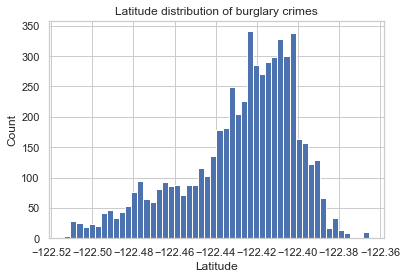

In [8]:
crime='BURGLARY'

# Filter the data by category and date
df2=policedata[(policedata["Category"] == crime)]
df2=df2[(df2["Date"] > '2016-01-01')
     &(df2["Date"] < '2017-01-01')]

#Plot the count of crimes by latitude coordinates
plt.hist(x=df2['X'], bins=50)
plt.title('Latitude distribution of burglary crimes')
plt.xlabel('Latitude')
plt.ylabel('Count')
plt.show()

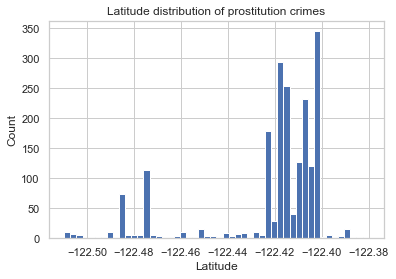

In [9]:
crime='PROSTITUTION'

# Filter the data by category and date
df2=policedata[(policedata["Category"] == crime)]
df2=df2[(df2["Date"] > '2014-01-01')
     &(df2["Date"] < '2018-01-01')]

#Plot the count of crimes by latitude coordinates
plt.hist(x=df2['X'], bins=50)
plt.title('Latitude distribution of prostitution crimes')
plt.xlabel('Latitude')
plt.ylabel('Count')
plt.show()

**Comments:** Plotting the latitude of the burglary and prostitution crimes enables us to display how the two crimes are geographically distributed in San Francisco. Altough the main peak in the two crimes is located at a similar latitude, it seems that the prostitution crimes are occurring in very specific areas. Instead, the burglary crimes are much more evenly spread across the territory. This might be due to the fact that prostitution happens in specific areas of the city while burglary is by definition occurring in different houses. It might also be due to the fact that the location of a prostitution crime might be more difficult to identify and thus a standard location might be reported. Conversely, people that file a burglary report also state the house address.

#### * Next up is using the plot-type shown in Figure 2-4 from DAOST, but with the data you used to create Figure 2.1. To create the kernel density plot, you can either use gaussian_kde from scipy.stats or you can use seaborn.kdeplot.

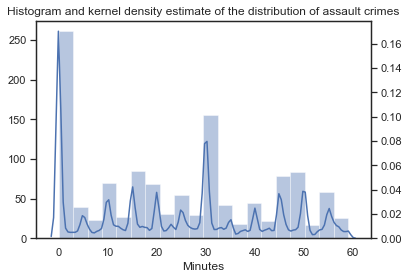

In [10]:
sns.set(style='white')
sns.distplot(df1.Minutes, kde=False, bins=20).set_title('Histogram and kernel density estimate of the distribution of assault crimes')
ax2 = plt.twinx()
sns.kdeplot(df1.Minutes, bw=.5, color="b", ax=ax2, legend=False)

#### * Finally, grab 25 random timepoints from the dataset (of 1000-10000 original data) you've just plotted and create a version of Figure 2-4 based on the 25 data points. Does this shed light on why I think KDEs can bee misleading?

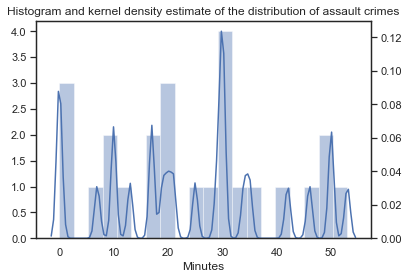

In [11]:
subset_df1=df1.sample(n=25)
sns.distplot(subset_df1.Minutes, kde=False, bins=20).set_title('Histogram and kernel density estimate of the distribution of assault crimes')
ax2 = plt.twinx()
sns.kdeplot(subset_df1.Minutes, bw=.5, color="b", ax=ax2, legend=False)
plt.show()

**Comments:** KDE plots are obtained by placing a kernel at the position of each data point and then adding up the contributions from all kernels. Given that KDE transforms the count of occurrences into a smooth curve and that the area under the curve formed by a single kernel is always 1, the number of observations is not explicitely communicated and might be overlooked. This might lead an observer to mistakenly make inferences about a population based on a graph built with a few observations. Indeed, based on the sample size, two similarly-shaped KDE curves might be more or less prepresentative of the underlying population.
A way to avoid this confusion is to plot, as done above, the histogram and the KDE plot and to display the two scales on two different y axes.

# Part 4: Heatmaps of geo-data

### Exercise: A new take on geospatial data using Folium (see the Week 4 exercises for full info and tutorials).

#### Now we look at studying geospatial data by plotting raw data points as well as heatmaps on top of actual maps.

#### First start by plotting a map of San Francisco with a nice tight zoom. Simply use the command folium.Map([lat, lon], zoom_start=13), where you'll have to look up San Francisco's longitude and latitude.

In [12]:
map_sf = folium.Map(location=[37.773972, -122.431297], zoom_start = 13)
map_sf

#### Next, use the the coordinates for SF City Hall 37.77919, -122.41914 to indicate its location on the map with a nice, pop-up enabled maker.

In [13]:
map_sf = folium.Map(location=[37.77919, -122.41914],
                        tiles="Stamen Toner", zoom_start = 12)
folium.Marker([37.77919, -122.41914], popup="City Hall").add_to(map_sf)
map_sf

#### Now, let's plot some more data (no need for popups this time). Select a couple of months of data for 'DRUG/NARCOTIC' and draw a little dot for each arrest for those two months. You could, for example, choose June-July 2016, but you can choose anything you like - the main concern is to not have too many points as this uses a lot of memory and makes Folium behave non-optimally. We can call this a kind of visualization a point scatter plot.

In [14]:
drug = policedata[(policedata.Category == "DRUG/NARCOTIC") &\
           (policedata.Date.dt.year == 2016) &\
           (policedata.Date.dt.month <= 7) &\
           (policedata.Date.dt.month >= 6)]

In [15]:
map_drug = folium.Map(location=[37.773972, -122.431297], zoom_start = 13)
for index, row in drug.iterrows():
    folium.CircleMarker([row.Y, row.X],fill_color='#43d9de', radius=2).add_to(map_drug)
map_drug

### Next, let's play with heatmaps. You can figure out the appropriate commands by grabbing code from the main tutorial) and modifying to suit your needs.

#### To create your first heatmap, grab all arrests for the category 'SEX OFFENSES, NON FORCIBLE' across all time. Play with parameters to get plots you like.

In [16]:
sex_data = policedata[policedata.Category == "SEX OFFENSES, NON FORCIBLE"]

In [17]:
map_sex = folium.Map(location=[37.763972, -122.431297], zoom_start = 12)
heat_data = [[row.Y,row.X] for index, row in sex_data.iterrows()]
HeatMap(heat_data, radius=20, max_zoom=20).add_to(map_sex)
map_sex

The maps parameters have been adjusted to be centered in San Francisco and at a zoom level which allows to have an overview of the distribution and intensity of the SEX OFFENSES crime over the whole city. 

The radius has also been adjusted to a smaller value than the default one, in order to show a more precise representation of the distribution. The default value resulted in a very wide red area which was not expressing accurately the higher intensity in some areas at this zoom level.

#### Now, comment on the differences between scatter plots and heatmaps. What can you see using the scatter-plots that you can't see using the heatmaps? And vice versa: what does the heatmaps help you see that's difficult to distinguish in the scatter-plots?

Heatmaps allow to easily visualize how dense of points an area on the map is, and immediately compare different densities from different areas to identify the one with the highest one. In a scatter plot points may overlap each other, and although it is possible to identify the most involved areas, it is not immediatly clear the density of a specific area, and it is therefore not easy to compare it with other ones.

On the other hand, heatmaps loose granularity and details since they do not plot each single crime occurrence individually but instead group them toghether in more smooth colored shapes. Scatter plots keep the detailed representation of each single occurrence and this can be desired in some cases.

#### Play around with the various parameter for heatmaps. You can find a list here: https://python-visualization.github.io/folium/plugins.html

In this version of the map, a wider perspective on the whole San Francisco has been adopted.
In order to maintain a visually meaningfull representation of the data density from such a wide angle, both the radius and the blur values have been reduced to 10.

In [18]:
zoom = 13
map_large_zoom = folium.Map(location=[37.773972, -122.431297], zoom_start = 11)
HeatMap(heat_data, blur=10, radius=10).add_to(map_large_zoom)
map_large_zoom

The next map is a close up of the SILVER TERRACE area. The area present a relatively small number of crime occurrences and therefore the radius has been increased to 20 to allow aggregation of crimes on a wider scala than in the previous map. Max_zoom has also been adjusted to allow the user to get to the highest intensity with only 2 zoom ins (max_zoom is set to 17, whereas the starting zoom level is 15).

In [19]:
zoom = 13
map_close_zoom = folium.Map(location=[37.731376, -122.396354], zoom_start = 15)
HeatMap(heat_data, max_zoom=17, radius=20).add_to(map_close_zoom)
map_close_zoom

#### Comment on the effect on the various parameters for the heatmaps. How do they change the picture? (at least talk about the radius and max_zoom)

By increasing the radius, we get less granularity and allow the map to aggregate points on a wider area. On the other hand, decreasing it will create geographically smaller aggregations of points and will colour red only very condensed aggregations of points, as for example our data has around the Hall of Justice. The radius should be changed according to the size of the areas we want to aggregate points from. For example if there is an interesting known risk-radius for a certain crime, the radius can be changed accordingly, or relative to the size of the area analyzed (i.e. for Copenhagen it would probably be wise to use a small radius, as crimes are locally more centered around hotspots, but if looking at the entirety of crimes in Denmark it may be wiser to have a larger radius).

Max_zoom allows to get the highest intensity of the points at the desired level of zoom. If max_zoom is high, the more we zoom in the map, the more intense the points will get (until we reach the max_zoom level). The lower the max_zoom the sooner the points will reach their highest intensity (given by the color, red for highest) and therefore, zooming in won't add much coloring information as it has already reached its highest intensity. Max_zoom should be adjusted according to the zoom level the map will be mostly looked at. If we are reppresenting data on a world scala and want to communicate the intensity of areas right at the user with no need of zooming in, it may be interesting to show the max intensity at a low level of zoom.

![maps](https://raw.githubusercontent.com/suneman/socialdataanalysis2020/master/files/crime_hot_spot.png)
#### In that screenshot, I've (manually) highlighted a specific hotspot for this type of crime. Use your detective skills to find out what's going on in that building on the 800 block of Bryant street ... and explain in your own words.

Many sex offences seem to occur in the area of the Hall of Justice at the 800 block of Bryant Street. This might be due to the fact that the people reporting sex offence crimes are not asked or are not able to recall the exact location where the crime occurred. The officials working at the Hall of Justice might then report the case by simply including the location of the office itself.

#### Start by choosing your favorite crimetype. Prefereably one with spatial patterns that change over time (use your data-exploration from the previous lectures to choose a good one).

The DISORDERLY CONDUCT crime has been chosen

In [20]:
crime = "DISORDERLY CONDUCT"
crime_data = policedata[policedata.Category == crime]

#### Now, choose a time-resolution. You could plot daily, weekly, monthly datasets to plot in your movie. Again the goal is to find interesting temporal patterns to display. We want at least 20 frames though.

The hourly pattern has been chosen

In [21]:
crime_data = crime_data.dropna(axis=0, subset=['X','Y', 'Hour'])

#### Create the movie using HeatMapWithTime

In [22]:
crime_heat_data = [[[row.Y,row.X]\
              for index, row in crime_data[(crime_data['Hour'] == j)]\
                   .iterrows()] for j in range(0,24)]

In [23]:
heat_map = folium.Map(location=[37.773972, -122.431297], zoom_start = 12)
folium.Marker([37.759588, -122.416461], popup="Mission").add_to(heat_map)
folium.Marker([37.784235, -122.413997], popup="Tenderloin").add_to(heat_map)

#
hm = plugins.HeatMapWithTime(crime_heat_data,auto_play=True,\
                             index=[[str(i)+":00"] for i in range (0,24)],\
                             radius=10,\
                             name="Disorderly")
hm.add_to(heat_map)
# Display the map
heat_map

#### Comment on your results:
 * What patterns does your movie reveal?
 * Motivate/explain the reasoning behind your choice of crimetype and time-resolution.

The movie reveals a specific pattern for the Disorderly Conduct crime: a spike in crimes takes place around 6-9 a.m and is concentrated in two main areas of the city districts: Mission and Tenderloin.
This information is useful for example in case the Police Department wanted to investigate further the causes of this specific behavior or wanted to increase the number of police forces in those areas during peak hours for fighting it.

The reason for plotting this specific crime on this time-resolution lies in a data analysis which has highlighted an interesting behavior for this crime type. Plotting all the focus crimes on an hourly basis showed that DISORDERLY CONDUCT had a peak crimes in a specific time window going from 6 to 9 in the morning and decreasing from there. It also showed another small peak around midnight.

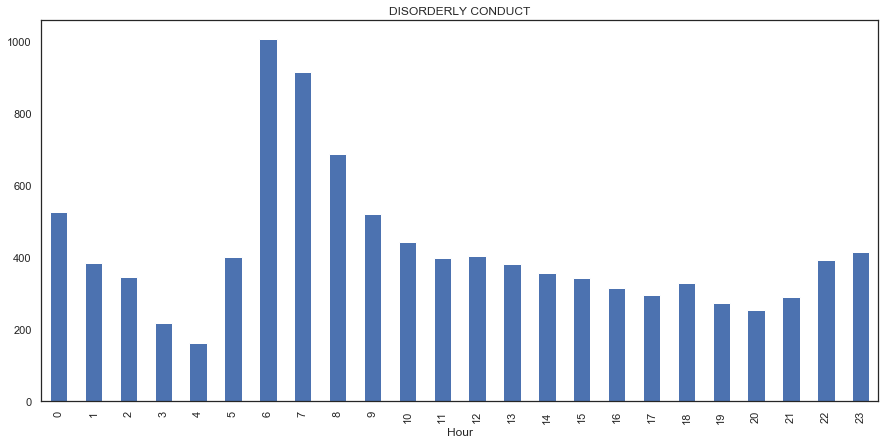

In [24]:
crime_data.groupby(policedata.Hour).count().IncidntNum.plot(kind='bar',title="DISORDERLY CONDUCT", figsize=(15,7))

Plotting the Latitude coordinate for focus crimes in a histogram, has showed that DISORDERLY CONDUCT has a specific area in which it occurs more frequently. Longitude has also been plotted and has shown a similar result.

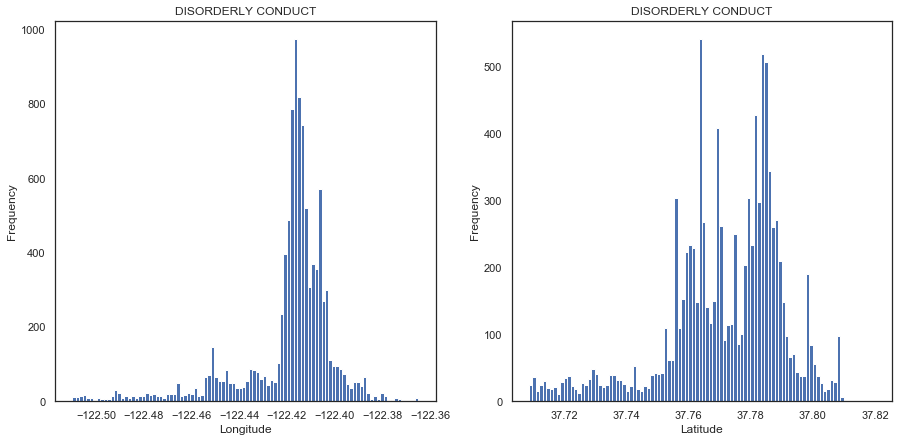

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

crime_data[crime_data.X < -122].X.plot(ax=axes[0], kind='hist',bins=100,title="DISORDERLY CONDUCT", figsize=(15,7))
axes[0].set_xlabel('Longitude')

crime_data[crime_data.Y < 50].Y.plot(ax=axes[1], kind='hist',bins=100,title="DISORDERLY CONDUCT", figsize=(15,7))
axes[1].set_xlabel('Latitude')

plt.show()

The interesting hourly and geographical patterns suited well a plotting tool such as the HeatMapWithTime which allows to combine the two different types of pattern in one visual and dynamic plot. The HeatMapWithTime has highlighted two main areas in which this type of crime takes place. A further anlysis plotting the distribution of occurrences of DIORDERLY CONDUCT in the different Police Department Districts, allowed to identify the two main affected ones: Mission and Tenderloin. Adding a marker for these districts on the HeatMapWithTime has shown to match with the main red areas.

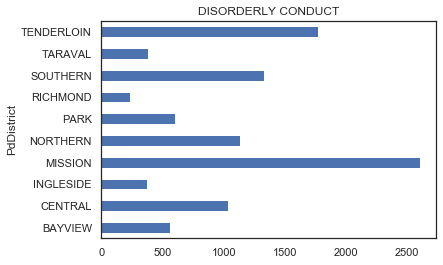

In [26]:
crime_data.groupby(crime_data.PdDistrict).count().IncidntNum.plot(kind='barh', title="DISORDERLY CONDUCT")

# Part 5: Errors in the data. 
### The importance of looking at raw (or close to raw) data.

#### We started the course by plotting simple histogram plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data.

#### In the hourly activity for PROSTITUTION something surprising is going on on Thursday. Remind yourself here, where I've highlighted the phenomenon I'm talking about.

#### When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself here, where I've highlighted the phenomenon I'm talking about.

#### And finally, today we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself here.

#### Exercise: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when we bin the data. We explore this process in the exercise below.

#### This last exercise for today has two parts.

#### * In each of the three examples above, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. Also briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).

**Answer:**

* Prostitution?

* The crimes being recorded more frequenlty in whole increments of 10/15 minutes is most likely due to an imprecision of the officials recording the time of the crime. This pattern is only visibile if we plot the data at the level of "minute". It causes the distribution to have multiple peaks and the summary statistics to be misleading. However, this does not impact more aggregated statistics, such as statistics at a hour, day, or month level. This imprecision in reporting the time of the crime might have implications when deciding how many people to employ at the police call center. Indeed, if the decision was aimed at reducing the waiting time, the minutes with the highest peak of crimes in an hour would determine the number of people to be employed. Since those peaks are artificial and do not reflect the real distirbution of the crimes, many more people than necessary would be employed in the call center.

* Many sex offences seem to occur at the Hall of Justice at the 800 block of Bryant Street  (https://sfpoa.org/about/contactus). This might be due to the fact that the people reporting sex offence crimes are not asked or are not able to recall the exact location where the crime occurred. The officials working at the Hall of Justice might then report the case by simply including the location of the office itself. This inaccurate data might lead policy analysts to draw wrong conclusions. Firstly, if the data was analysed at an aggregated neighborhood level, the neighborhood where the Hall of Justice is located could be depicted as a very dangerous one. Consequently, on the one hand, excessive investments (lights, police activity, prevention initiatives) might be made to increase the safety of this urban area. On the other hand, the more dangerous areas would not be identified and, therefore, the problem would not be addressed. It might even happen that some investements are transferred from the dangerous areas to neighborhood where the Hall of Justice is located. Secondly, if the data was analysed at a detailed street address level without considering the possibility of errors, one might erroneously conclude that many sex offences occur in the Hall of Justice itself. An inexperienced journalist could claim that many sex offences are perpetrated by the police officers.

#### * (Optional) Find your own example of human noise in the data and visualize it.

When plotting Longitude and Latitude for the DISORDERLY CONDUCT crime, the histogram showed the presence of outliers as the x axis was relatively wide compared to the visible bins

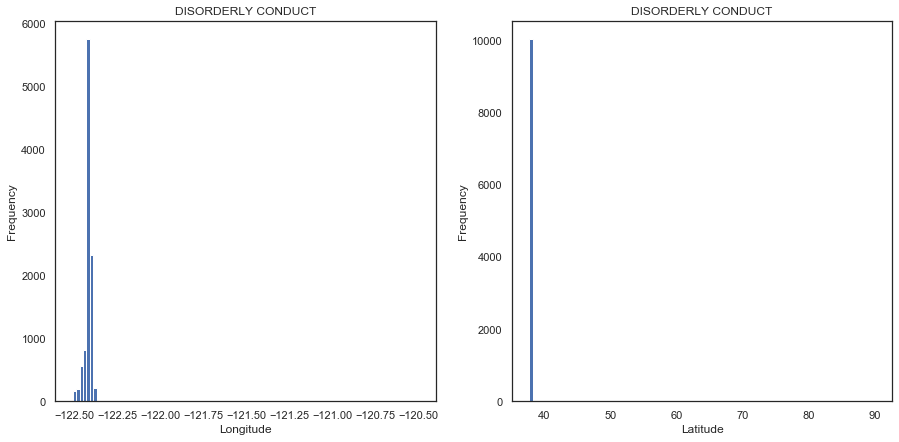

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

crime_data.X.plot(ax=axes[0], kind='hist',bins=100,title="DISORDERLY CONDUCT", figsize=(15,7))
axes[0].set_xlabel('Longitude')

crime_data.Y.plot(ax=axes[1], kind='hist',bins=100,title="DISORDERLY CONDUCT", figsize=(15,7))
axes[1].set_xlabel('Latitude')

plt.show()

Filtering the data to identify what and how many values where widening the axis, 2 have been found to be the outliers for both the Latitude and Longitude

In [28]:
crime_data[crime_data.Y > 50]

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,DateTime,Hour,Month,Minutes,TimeFormatted
466379,40719700,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,3,2004-06-24,00:03,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.5 90),4071970019010,2004-06-24 00:03:00,0,6,3,00:03:00
669457,40310314,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,2,2004-03-17,01:16,NORTHERN,"ARREST, BOOKED",LARKIN ST / AUSTIN ST,-120.5,90.0,POINT (-120.5 90),4031031419010,2004-03-17 01:16:00,1,3,16,01:16:00


In [29]:
crime_data[crime_data.X > -122]

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,DateTime,Hour,Month,Minutes,TimeFormatted
466379,40719700,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,3,2004-06-24,00:03,NORTHERN,"ARREST, BOOKED",AUSTIN ST / LARKIN ST,-120.5,90.0,POINT (-120.5 90),4071970019010,2004-06-24 00:03:00,0,6,3,00:03:00
669457,40310314,DISORDERLY CONDUCT,COMMITTING PUBLIC NUISANCE,2,2004-03-17,01:16,NORTHERN,"ARREST, BOOKED",LARKIN ST / AUSTIN ST,-120.5,90.0,POINT (-120.5 90),4031031419010,2004-03-17 01:16:00,1,3,16,01:16:00


Plotting these two crimes on a map showed that the location is outside San Francisco and even outside the world. This means that these crimes contain errors in their location data.

In [30]:
heat_map = folium.Map(location=[37.773972, -122.431297], zoom_start = 0)
#
for index, crime_occ in crime_data[crime_data.Y > 80].iterrows():
    folium.Marker([crime_occ.Y, crime_occ.X]).add_to(heat_map)

heat_map

By plotting all the crimes in a jitter plot over their Longitude and Latitude, we identify the presence of many outliers such as the two identified previously

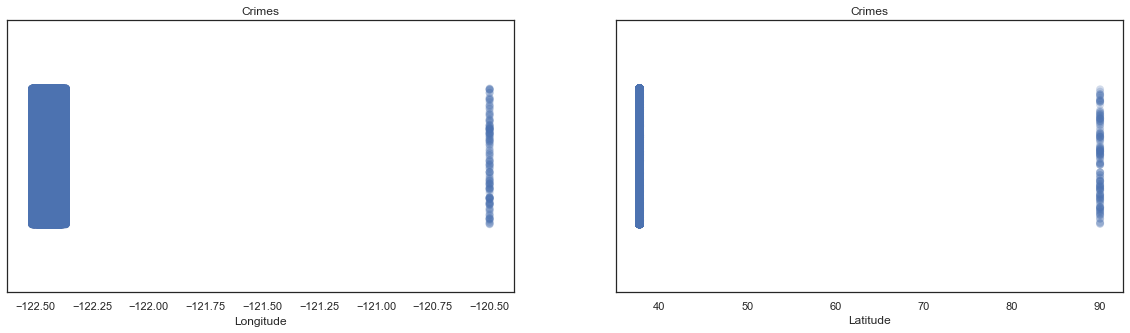

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.stripplot(x="X", data=policedata, edgecolor="gray", alpha=.25,size=8, jitter=0.25, ax=axes[0])
axes[0].set_xlabel('Longitude')
axes[0].set_title('Crimes')

sns.stripplot(x="Y", data=policedata, edgecolor="gray", alpha=.25,size=8, jitter=0.25, ax=axes[1])
axes[1].set_xlabel('Latitude')
axes[1].set_title('Crimes')

plt.show()

The count of such crimes affected by this error is 143

In [ ]:
len(data[(data['Y'] > 40)&(data['X'] > -122.00)])